In [1]:
import os
import tarfile
from urllib.request import urlretrieve
from pathlib import Path

import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
# Step 1: Define GEO dataset (kidney organoid example)
geo_datasets = {
    "GSE216481": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE216481&format=file",
}

os.makedirs("./raw_data", exist_ok=True)
os.makedirs("./processed", exist_ok=True)


In [3]:
# Step 2: Download and extract dataset
for gse, url in geo_datasets.items():
    tar_path = f"./raw_data/{gse}.tar"
    extract_path = f"./raw_data/{gse}"
    if not os.path.exists(tar_path):
        print(f"⬇️ Downloading {gse}...")
        urlretrieve(url, tar_path)
    if not os.path.exists(extract_path):
        print(f"📦 Extracting {gse}...")
        with tarfile.open(tar_path) as tar:
            tar.extractall(path=extract_path)

⬇️ Downloading GSE216481...
📦 Extracting GSE216481...


In [5]:
from pathlib import Path

# 设置数据路径
data_dir = Path("./raw_data/GSE216481")  # 替换成你实际的数据路径

# 获取所有文件（递归查找）
all_files = list(data_dir.rglob("*"))

# 输出文件路径和数量
print(f"🔍 Found {len(all_files)} files:\n")
for f in all_files:
    print(f)


🔍 Found 167 files:

raw_data\GSE216481\GSM6674255_191108_TFv2d56_4w_S1_barcodes.tsv.gz
raw_data\GSE216481\GSM6674255_191108_TFv2d56_4w_S1_features.tsv.gz
raw_data\GSE216481\GSM6674255_191108_TFv2d56_4w_S1_matrix.mtx.gz
raw_data\GSE216481\GSM6674256_191108_TFv2d56_4w_S2_barcodes.tsv.gz
raw_data\GSE216481\GSM6674256_191108_TFv2d56_4w_S2_features.tsv.gz
raw_data\GSE216481\GSM6674256_191108_TFv2d56_4w_S2_matrix.mtx.gz
raw_data\GSE216481\GSM6674257_191108_TFv2d56_8w_S1_barcodes.tsv.gz
raw_data\GSE216481\GSM6674257_191108_TFv2d56_8w_S1_features.tsv.gz
raw_data\GSE216481\GSM6674257_191108_TFv2d56_8w_S1_matrix.mtx.gz
raw_data\GSE216481\GSM6674258_191108_TFv2d56_8w_S2_barcodes.tsv.gz
raw_data\GSE216481\GSM6674258_191108_TFv2d56_8w_S2_features.tsv.gz
raw_data\GSE216481\GSM6674258_191108_TFv2d56_8w_S2_matrix.mtx.gz
raw_data\GSE216481\GSM6674380_200209_DS_S1_barcodes.tsv.gz
raw_data\GSE216481\GSM6674380_200209_DS_S1_features.tsv.gz
raw_data\GSE216481\GSM6674380_200209_DS_S1_matrix.mtx.gz
raw_data\

In [6]:
import scanpy as sc
from pathlib import Path

sample_ids = [
    "GSM6674255_191108_TFv2d56_4w_S1",
    "GSM6674256_191108_TFv2d56_4w_S2",
    "GSM6674257_191108_TFv2d56_8w_S1",
    "GSM6674380_200209_DS_S1",
    "GSM6674382_200209_EB_S1"
]

data_dir = Path("./raw_data/GSE216481")
all_adata = []

for sid in sample_ids:
    ad = sc.read_10x_mtx(
        data_dir,
        var_names="gene_symbols",
        prefix=sid + "_",
        cache=True
    )
    ad.var_names_make_unique()
    ad.obs["sample"] = sid
    all_adata.append(ad)

# 合并
adata = all_adata[0].concatenate(*all_adata[1:], batch_key="sample", batch_categories=sample_ids)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13928\60522500.py:27: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = all_adata[0].concatenate(*all_adata[1:], batch_key="sample", batch_categories=sample_ids)


In [7]:
adata.var_names_make_unique()

In [8]:
adata

AnnData object with n_obs × n_vars = 50000 × 33538
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [9]:
# Step 4: Quality control and filtering
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_counts=30000)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
adata

AnnData object with n_obs × n_vars = 42777 × 23366
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [11]:
# Step 4.5: Check data matrix before normalization and neighbor computation
print(f"📊 Matrix shape: {adata.shape}")
if np.isnan(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X).any():
    raise ValueError("❌ Detected NaNs in expression matrix.")
if np.max(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X) == 0:
    raise ValueError("❌ Expression matrix contains only zeros.")


📊 Matrix shape: (42777, 23366)


In [12]:
# Step 5: Normalize and compute neighbors
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
try:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
except ValueError as e:
    print("⚠️ highly_variable_genes failed with error:", e)
    print("📉 Falling back to top_n method (flavor='seurat_v3')")
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, key_added="cluster")
sc.tl.umap(adata)

d:\anaconda3\envs\scCNA_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13928\1671630509.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="cluster")


In [13]:
adata

AnnData object with n_obs × n_vars = 42777 × 23366
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cluster'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'cluster', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

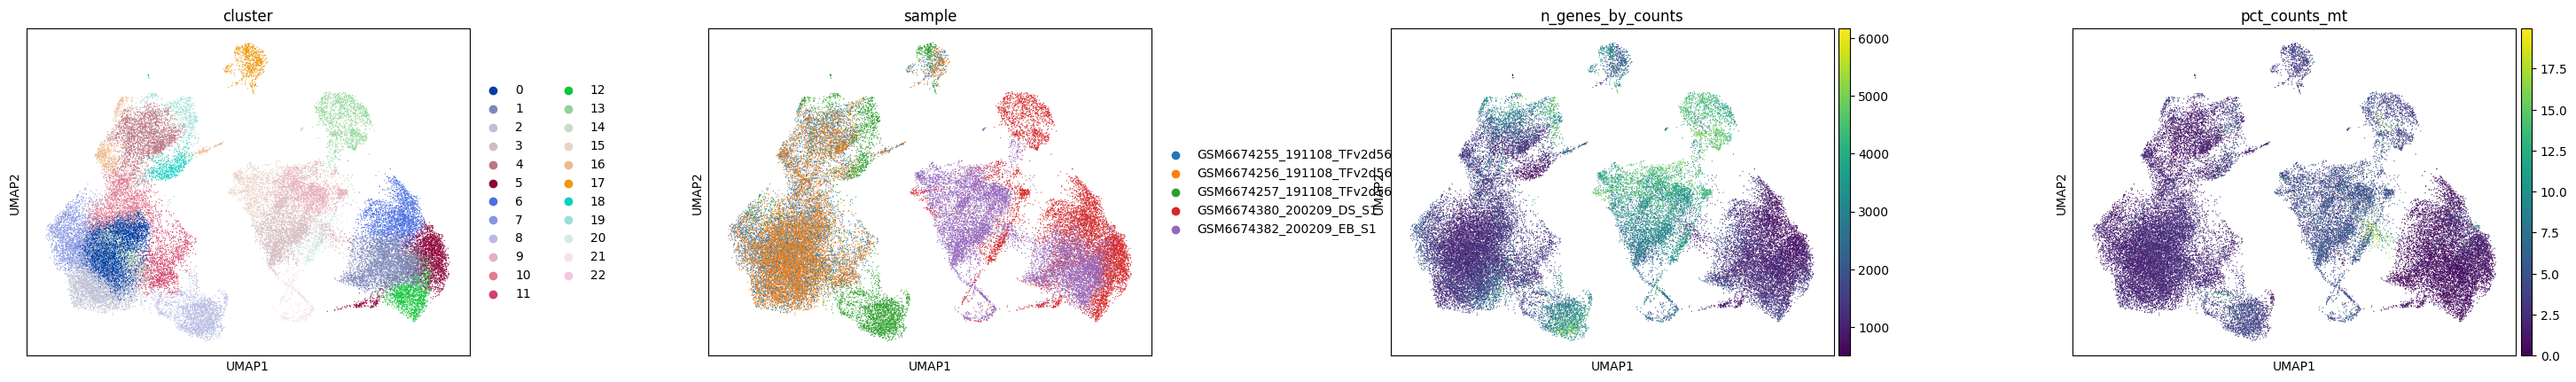

d:\anaconda3\envs\scCNA_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\anaconda3\envs\scCNA_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\anaconda3\envs\scCNA_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\anaconda3\envs\scCNA_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\anaconda3\envs\scCNA_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\anaconda3\envs\scCNA_env\lib\site-packages\scan

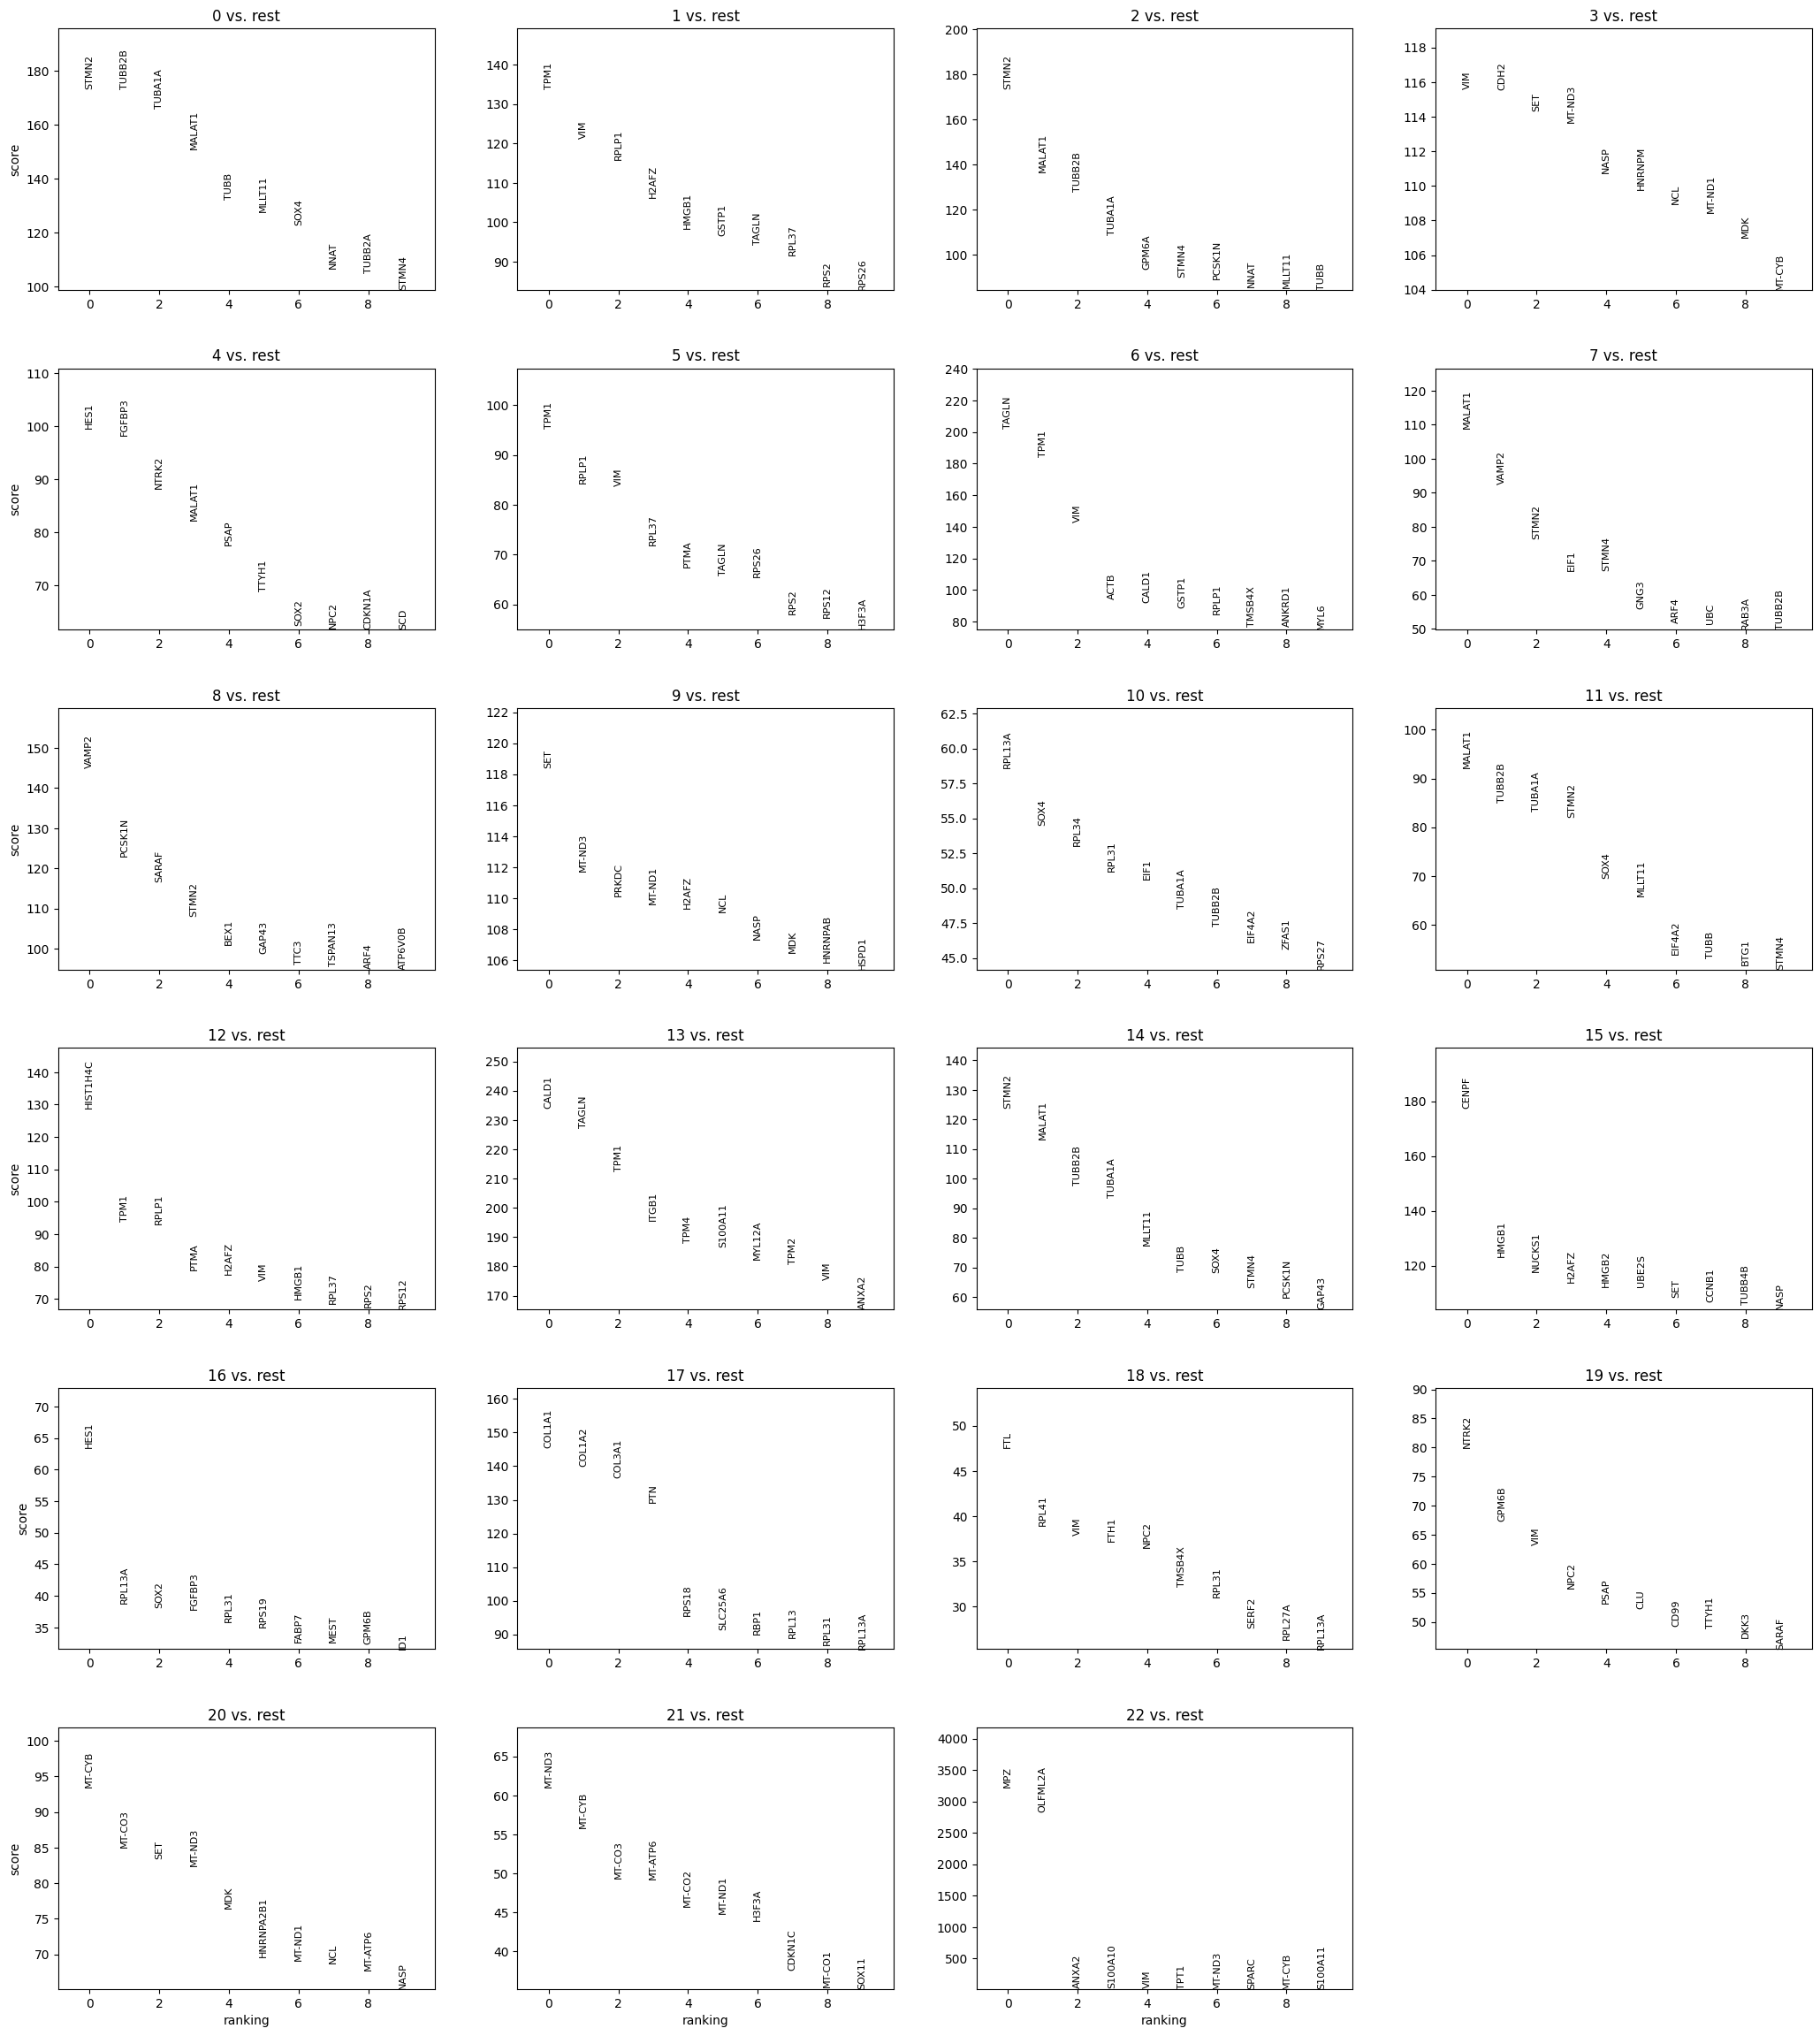

In [14]:
# Step 6: Plot and rank genes
sc.pl.umap(adata, color=["cluster", "sample", "n_genes_by_counts", "pct_counts_mt"], wspace=0.4)
sc.tl.rank_genes_groups(adata, groupby="cluster", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

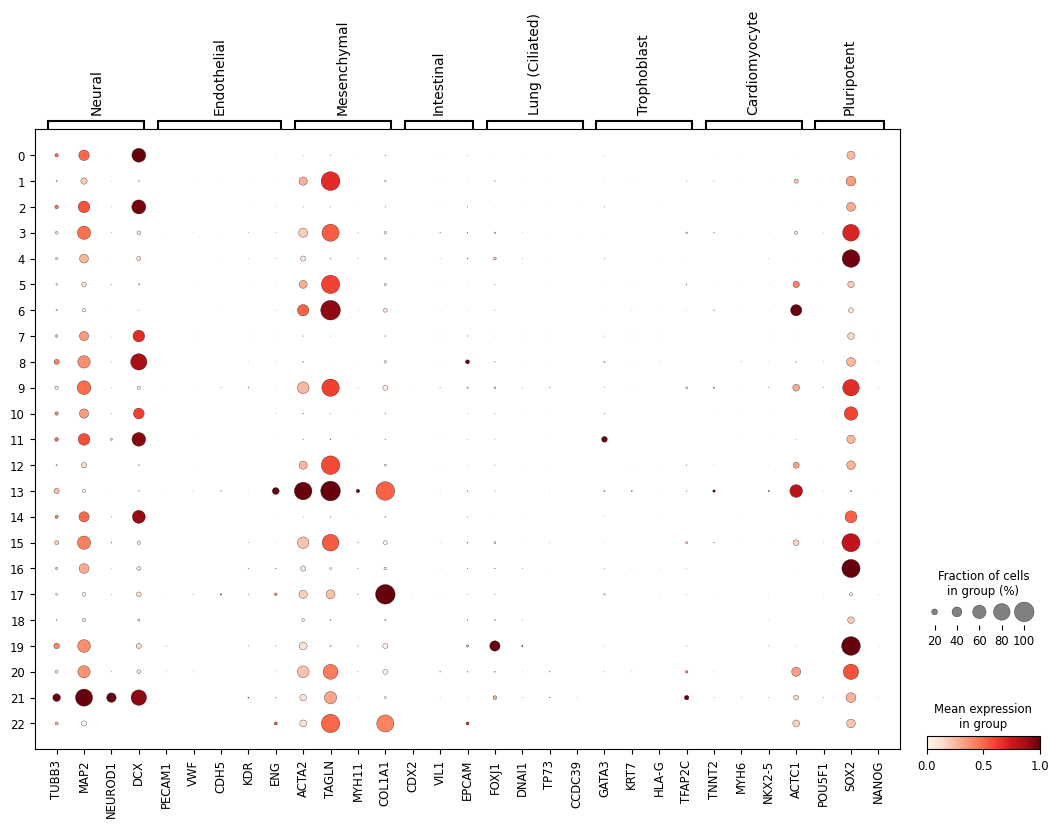

In [15]:
# Step 7: Marker genes for kidney organoids
marker_genes = {
    "Neural": ["TUBB3", "MAP2", "NEUROD1", "DCX", "NEUN"],
    "Endothelial": ["PECAM1", "VWF", "CDH5", "KDR", "ENG"],
    "Mesenchymal": ["ACTA2", "TAGLN", "MYH11", "COL1A1"],
    "Intestinal": ["CDX2", "VIL1", "MUC2", "EPCAM"],
    "Lung (Ciliated)": ["FOXJ1", "DNAI1", "TP73", "CCDC39"],
    "Trophoblast": ["GATA3", "KRT7", "HLA-G", "TFAP2C"],
    "Cardiomyocyte": ["TNNT2", "MYH6", "NKX2-5", "ACTC1"],
    "Pluripotent": ["POU5F1", "SOX2", "NANOG"],
}
# Filter marker genes to those present in the dataset
valid_genes = {k: [g for g in v if g in adata.var_names] for k, v in marker_genes.items() if any(g in adata.var_names for g in v)}
sc.pl.dotplot(adata, valid_genes, groupby="cluster", standard_scale="var")

In [16]:
# Step 8: Annotate cell types manually based on cluster
celltype_dict = {
    '0': 'Neural',
    '1': 'Endothelial',
    '2': 'Mesenchymal',
    '3': 'Intestinal',
    '4': 'Lung (Ciliated)',
    '5': 'Trophoblast',
    '6': 'Cardiomyocyte',
    '7': 'Pluripotent',
}
adata.obs['cell_type'] = adata.obs['cluster'].map(celltype_dict)

In [17]:
# Step 9: Save processed object with cell type annotation
adata.write("./processed/GSE216481_cleaned_annotated.h5ad")
print("✅ Saved annotated AnnData to ./processed/GSE216481_cleaned_annotated.h5ad")

✅ Saved annotated AnnData to ./processed/GSE216481_cleaned_annotated.h5ad


In [18]:
adata

AnnData object with n_obs × n_vars = 42777 × 23366
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'cluster', 'umap', 'cluster_colors', 'sample_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'